In [19]:
import argparse
import os,sys
import numpy as np
import math

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.transforms import ToTensor, Lambda

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [20]:
# Setup device-agnostic code 
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "cpu" # Apple GPU
else:
    device = "cpu"

print(device)

cpu


In [21]:
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
sample_interval = 400

In [22]:
import pandas as pd
import os

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

class ChineseMNISTDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.img_labels = pd.read_csv('../data/chinese_mnist/chinese_mnist.csv')
        self.img_dir = '../data/chinese_mnist/data/data'
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        suite_id,sample_id,code,value, _ = self.img_labels.iloc[idx]
        img_name = 'input_{0}_{1}_{2}.jpg'.format(suite_id,sample_id, code)
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)
        label = code
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [23]:

os.makedirs("images", exist_ok=True)

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False
mps = True if torch.backends.mps.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [24]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
                                
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

if mps:
    generator.to(device)
    discriminator.to(device)
    adversarial_loss.to(device)

train_data = datasets.MNIST(
    root='../data/mnist',
    train=True,
    transform=transform, 
    #把灰階從0~255壓縮到0~1
    download=True
)

# Configure data loader
dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size= batch_size,
    shuffle=True,
)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


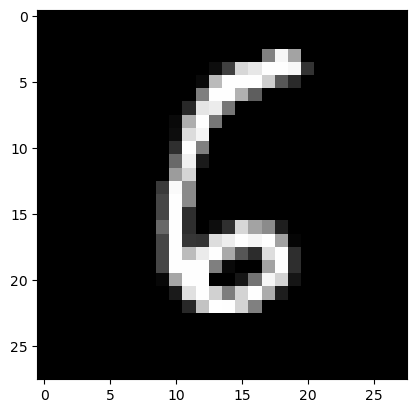

Label: 6


In [25]:
# Display image and label.
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


In [26]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
print(Tensor)

<class 'torch.FloatTensor'>


In [27]:
# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()



        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)


[Epoch 0/200] [Batch 0/938] [D loss: 0.694808] [G loss: 0.716732]
[Epoch 0/200] [Batch 400/938] [D loss: 0.400874] [G loss: 1.211501]
[Epoch 0/200] [Batch 800/938] [D loss: 0.510320] [G loss: 0.557101]
[Epoch 1/200] [Batch 262/938] [D loss: 0.350319] [G loss: 1.529854]
[Epoch 1/200] [Batch 662/938] [D loss: 0.382688] [G loss: 1.048612]
[Epoch 2/200] [Batch 124/938] [D loss: 0.274201] [G loss: 1.199351]
[Epoch 2/200] [Batch 524/938] [D loss: 0.283112] [G loss: 1.149648]
[Epoch 2/200] [Batch 924/938] [D loss: 0.300300] [G loss: 1.187628]
[Epoch 3/200] [Batch 386/938] [D loss: 0.294107] [G loss: 1.461770]
[Epoch 3/200] [Batch 786/938] [D loss: 0.390284] [G loss: 3.344377]
[Epoch 4/200] [Batch 248/938] [D loss: 0.253754] [G loss: 1.882399]
[Epoch 4/200] [Batch 648/938] [D loss: 0.215256] [G loss: 2.092250]
[Epoch 5/200] [Batch 110/938] [D loss: 0.670947] [G loss: 5.730659]
